# Import 

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import os
import pickle
import glob
from scipy import ndimage
from datetime import datetime
# from scipy.ndimage.interpolation import rotate
# from PIL import Image
%matplotlib inline

import tools
import structure

# PrePare

In [2]:
# Prepare variables
V = tools.Vars()
# V.put('data_dir', os.getcwd() + "/../full_data_cell/")
# V.put('data_dir', os.getcwd() + "/../full_data_cell_bgrm/")
V.put('data_dir', "/root/data/cell_unscale")
V.put('cell_xy_file', "/root/data/cell_unscale/cell_xy.p")
V.put('cell_x', 140)
V.put('cell_y', 280)
V.put('size_re', 128)
V.put('test_set_size', 4096)
V.put('batch_size', 64)
V.put('learning_rate_init', 0.003)
V.put('lr_change_std', 4000)
V.put('training_iters', 200000)
V.put('display_step', 100)
V.put('save_step', 3000)
V.put('do_bn', True)
V.put('do_l2', False)
V.put('l2_rate', 0.00003)
V.put('boardDir', "./board")
V.put('expTag', "CompactCNN")
V.put('expName', datetime.today().strftime("%Y%m%d_%H%M_") + "16.32.64.128.512.512_e003heu_CWAtt")
V.put('model_save_path', "./model/{}/{}".format(V.get('expTag'), V.get('expName')))

In [3]:
def cord2grid(V, cord) :
    slc_num_x = V.get('slc_num_x')
    slc_num_y = V.get('slc_num_y')
    cord_flatten = cord[:,1]*slc_num_x + cord[:,0]
    cord_hot = tf.one_hot(cord_flatten, slc_num_x*slc_num_y, name="cord_hot")
#     cord_hot1 = tf.one_hot(cord[:,0], slc_num_y)
#     cord_hot2 = tf.one_hot(cord[:,1], slc_num_x)
#     cord_hot = tf.concat([cord_hot1, cord_hot2], 1)
#     cord_hot = tf.reshape(cord_hot, [-1, slc_num_y, slc_num_x], name="cord_hot")
    return tf.cast(cord_hot, tf.float32)

# def partition_by_class(V, fList, cList, xyList, cDic) :
# #     test_set_size = V.get('test_set_size')
# #     train_set_size = len(fList) - test_set_size
# #     V.put("train_set_size", train_set_size)
#     partitions = np.random.permutation(len(fList))
#     files_error1 = [ [] for i in range(V.get('n_output')) ]
#     labels_error1 = [ [] for i in range(V.get('n_output')) ]
#     files_errorn = [ [] for i in range(V.get('n_output')) ]
#     labels_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_files_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_labels_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_xys = []
#     for i in range(V.get('n_output')) :
#         for p in partitions :
#             if cList[p] == i :
#                 if len(fList[p]) == 1 :
#                     files_error1[i].append(fList[p])
#                     labels_error1[i].append(cList[p])
#                 elif len(fList[p]) >= 2 :
#                     files_errorn[i].append(fList[p])
#                     labels_errorn[i].append(cList[p])
# #                 elif len(fList[p]) > 2 :
# #                     test_files_errorn[i].append(fList[p])
# #                     test_labels_errorn[i].append(cList[p])
#                 else :
#                     print len(fList[p])
#     for i in range(len(files_error1)) :
#         print len(files_error1[i]), len(files_errorn[i])
#     print "Separation by error done"
    
#     train_f_list = []
#     train_l_list = []
#     test_files_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_labels_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_files_errorn = [ [] for i in range(V.get('n_output')) ]
#     test_labels_errorn = [ [] for i in range(V.get('n_output')) ]
#     max_n = 500
#     for i in range(V.get('n_output')) :
#         if len(files_error1[i]) > max_n :
#             m = 100
#         else :
#             m = len(files_error1[i])/5
#         test_files_error1[i].extend(files_error1[i][:m])
#         test_labels_error1[i].extend(labels_error1[i][:m])
#         for j in range(len(files_error1[i])-m) :
#             train_f_list.extend(files_error1[i][m+j])
#             train_l_list.extend([ labels_error1[i][m+j] for k in range(len(files_error1[i][m+j]))])
        
#         if len(files_errorn[i]) > max_n :
#             m = 100
#         else :
#             m = len(files_errorn[i])/5
#         test_files_errorn[i].extend(files_errorn[i][:m])
#         test_labels_errorn[i].extend(labels_errorn[i][:m])
#         for j in range(len(files_errorn[i])-m) :
#             train_f_list.extend(files_errorn[i][m+j])
#             train_l_list.extend([ labels_errorn[i][m+j] for k in range(len(files_errorn[i][m+j]))])
        
# #     train_f_list = list(itertools.chain.from_iterable(train_f_list))
    
#     test_images_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_images_errorn = [ [] for i in range(V.get('n_output')) ]
#     for i in range(V.get('n_output')) :
#         for fs in test_files_error1[i] :
#             imgs = []
#             for f in fs :
#                 imgs.append(ndimage.imread(f))
#             test_images_error1[i].append(np.array(imgs))
#         for fs in test_files_errorn[i] :
#             imgs = []
#             for f in fs :
#                 imgs.append(ndimage.imread(f))
#             test_images_errorn[i].append(np.array(imgs))
    
#     test_images = []
#     test_labels = []
#     for i in range(V.get('n_output')) :
#         test_images.extend(test_images_error1[i])
#         test_labels.extend(test_labels_error1[i])
#         test_images.extend(test_images_errorn[i])
#         test_labels.extend(test_labels_errorn[i])
        
#     V.put('test_set_size', len(test_images))
#     print "Partition done"
#     return [train_f_list, train_l_list, test_images, test_labels, 
#             test_images_error1, test_labels_error1, test_images_errorn, test_labels_errorn]

def current_model(V, x, y, cord, phase, keep_prob, learning_rate) :
    n_c1 = 16
    n_c2 = 32
    n_c3 = 64
    n_c4 = 128
    n_fc1 = 512
    n_fc2 = 512
    n_output = V.get('n_output')

    with tf.name_scope("Weight") :
        W = {"c1_1" : tf.Variable(tf.truncated_normal([3, 3, 3, n_c1], stddev=0.1), name="w_c1_1"),
            "c1_2" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c1], stddev=0.1), name="w_c1_2"),
            "c2_1" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c2], stddev=0.1), name="w_c2_1"),
            "c2_2" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c2], stddev=0.1), name="w_c2_2"),
            "c3_1" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c3], stddev=0.1), name="w_c3_1"),
            "c3_2" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1), name="w_c3_2"),
            "c4_1" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c4], stddev=0.1), name="w_c4_1"),
            "c4_2" : tf.Variable(tf.truncated_normal([3, 3, n_c4, n_c4], stddev=0.1), name="w_c4_2"),
            "fc1" : tf.Variable(tf.truncated_normal([8*8*n_c4, n_fc1], stddev=0.1), name="w_fc1"),
            "fc2" : tf.Variable(tf.truncated_normal([n_fc1, n_fc2], stddev=0.1), name="w_fc2"),
            "out" : tf.Variable(tf.truncated_normal([n_fc2, n_output], stddev=0.1), name="w_out")}

    with tf.name_scope("Bias") :
        B = {"c1_1" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_1"),
            "c1_2" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_2"),
            "c2_1" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_1"),
            "c2_2" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_2"),
            "c3_1" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_1"),
            "c3_2" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_2"),
            "c4_1" : tf.Variable(tf.random_normal([n_c4], stddev=0.1), name="b_c4_1"),
            "c4_2" : tf.Variable(tf.random_normal([n_c4], stddev=0.1), name="b_c4_2"),
            "fc1" : tf.Variable(tf.random_normal([n_fc1], stddev=0.1), name="b_fc1"),
            "fc2" : tf.Variable(tf.random_normal([n_fc2], stddev=0.1), name="b_fc2"),
            "out" : tf.Variable(tf.random_normal([n_output], stddev=0.1), name="b_out")}
        
    with tf.name_scope("Weigth_coord") :
        W_c = {"fc1" : tf.Variable(tf.truncated_normal([7*4, n_fc2*n_output], stddev=0.1), name="w_fc1")}
    with tf.name_scope("Bias_coord") :
        B_c = {"fc1" : tf.Variable(tf.random_normal([n_fc2*n_output], stddev=0.1), name="b_fc1")}

#     pool1 = structure.conv33pool2(x, W["c1_1"], B["c1_1"], W["c1_2"], B["c1_2"], phase, keep_prob,
#                                   "conv1_1", "conv1_2", "pool1", "Conv1",
#                                  do_bn=V.get('do_bn'))
#     pool2 = structure.conv33pool2(pool1, W["c2_1"], B["c2_1"], W["c2_2"], B["c2_2"], phase, keep_prob,
#                                   "conv2_1", "conv2_2", "pool2", "Conv2",
#                                  do_bn=V.get('do_bn'))
#     pool3 = structure.conv33pool2(pool2, W["c3_1"], B["c3_1"], W["c3_2"], B["c3_2"], phase, keep_prob, 
#                                   "conv3_1", "conv3_2", "pool3", "Conv3",
#                                  do_bn=V.get('do_bn'))
#     pool4 = structure.conv33pool2(pool3, W["c4_1"], B["c4_1"], W["c4_2"], B["c4_2"], phase, keep_prob, 
#                                   "conv4_1", "conv4_2", "pool4", "Conv4",
#                                  do_bn=V.get('do_bn'))
#     pool4 = tf.reshape(pool4, [-1, 8*8*n_c4])
    
    # conv 5 pool 2
    W1 = [W["c1_1"], W["c1_2"]]
    B1 = [B["c1_1"], B["c1_2"]]
    S1 = [[1,1,1,1], [1,1,1,1], [1,2,2,1]]
    N1 = ["conv1_1", "conv1_2", "pool1"]
    pool1 = structure.conv_univ(x, W1, B1, S1, N1, phase, "Conv1", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W2 = [W["c2_1"], W["c2_2"]]
    B2 = [B["c2_1"], B["c2_2"]]
    S2 = [[1,1,1,1], [1,1,1,1], [1,2,2,1]]
    N2 = ["conv2_1", "conv2_2", "pool2"]
    pool2 = structure.conv_univ(pool1, W2, B2, S2, N2, phase, "Conv2", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W3 = [W["c3_1"], W["c3_2"]]
    B3 = [B["c3_1"], B["c3_2"]]
    S3 = [[1,1,1,1], [1,1,1,1], [1,2,2,1]]
    N3 = ["conv3_1", "conv3_2", "pool3"]
    pool3 = structure.conv_univ(pool2, W3, B3, S3, N3, phase, "Conv3", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W4 = [W["c4_1"], W["c4_2"]]
    B4 = [B["c4_1"], B["c4_2"]]
    S4 = [[1,1,1,1], [1,1,1,1], [1,2,2,1]]
    N4 = ["conv4_1", "conv4_2", "pool4"]
    pool4 = structure.conv_univ(pool3, W4, B4, S4, N4, phase, "Conv4", do_bn=V.get('do_bn'))
    
    # reshape
    pool4 = tf.reshape(pool4, [-1, 8*8*n_c4])

    # fully connected
    fc1 = structure.fc_univ(pool4, W["fc1"], B["fc1"], "fc1", phase, "FC1", do_bn=V.get('do_bn'))
    fc2 = structure.fc_univ(fc1, W["fc2"], B["fc2"], "fc2", phase, "FC2", do_bn=V.get('do_bn'))
    
    with tf.name_scope("Coord") :
        fc_coord = tf.nn.bias_add(tf.matmul(cord, W_c["fc1"]), B_c["fc1"])
        fc_coord = tf.layers.batch_normalization(fc_coord, axis=1, center=True, scale=True, training=phase)
        fc_coord = tf.nn.relu(fc_coord, name="fc_coord")
        tf.summary.histogram("weights", W_c["fc1"])
        tf.summary.histogram("bias", B_c["fc1"])
        tf.summary.histogram("activations", fc_coord)
        fc_coord = tf.reshape(fc_coord, [-1, n_fc2, n_output])

    with tf.name_scope("OUT") :
        W_tiled = tf.tile(tf.expand_dims(W["out"],0), [tf.shape(x)[0],1,1], name="W_tiled")
        W_att = tf.multiply(W_tiled, fc_coord, name="W_att")
        fc2_tiled = tf.tile(tf.expand_dims(fc2,2), [1,1,n_output], name="fc2_tiled")
        out = tf.reduce_sum(fc2_tiled*W_att, axis=1)
        out = tf.nn.bias_add(out, B["out"], name="out")
#         out = tf.nn.bias_add(tf.matmul(fc2, W["out"]), B["out"], name="out")
        tf.summary.histogram("weights", W["out"])
        tf.summary.histogram("bias", B["out"])
        tf.summary.histogram("activations", out)

    with tf.name_scope("Cost") :
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y), name="loss")
        if V.get('do_l2') :
            loss = loss + V.get('l2_rate')*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops) :
            opt = tf.train.AdamOptimizer(learning_rate=learning_rate, name="adam").minimize(loss, name="opt")

    with tf.name_scope("Accuracy") :
        corPred = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1), name="corPred")
        acc = tf.reduce_mean(tf.cast(corPred, tf.float32), name="acc")

    with tf.name_scope("AvgPred") :
        intm = tf.reduce_mean(out, axis=0)
        sm = tf.nn.softmax(out, name="sm")
        sm_intm = tf.reduce_mean(sm, axis=0, name="sm_intm")
        pred_test = tf.argmax(sm_intm)
        loss_avg = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=intm, labels=y), name="loss_avg")
        acc_avg = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(sm_intm), tf.argmax(y, 1)), tf.float32), name="acc_avg")

    print "Structure build Complete"
    return [loss, opt, corPred, acc, pred_test, loss_avg, acc_avg]

print "Function Definition Done"

Function Definition Done


# Run

In [4]:
# Create session
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
print "Session Created"

Session Created


In [5]:
# Prepare
rm_list = ["PASS", "NORMAL"]
x_grid_std = [0, 38, 77, 100, 128]
y_grid_std = [0, 18, 36, 54, 77, 93, 109, 128]
V.put('slc_num_x', len(x_grid_std)-1)
V.put('slc_num_y', len(y_grid_std)-1)
fList, cList, xyList, cDic = tools.load_data_cell(V, rm_list, x_grid_std, y_grid_std)
[train_f_list, train_l_list, train_xy_list, 
 test_images, test_labels, test_xys] = tools.partition(V, fList, cList, xyList, cDic)
# [train_f_list, train_l_list, test_images, test_labels,
#  test_images_error1, test_labels_error1, 
#  test_images_errorn, test_labels_errorn] = partition_by_class(V, fList, cList, xyList, cDic)

# train_f_list, train_l_list = undersampling(train_f_list, train_l_list, cDic)
# train_f_list, train_l_list = oversampling(train_f_list, train_l_list, cDic)
# train_xy_list = [[]]*len(train_f_list)
train_image_batch, train_label_batch, train_xy_batch = tools.pipeline_train(V, train_f_list, train_l_list, train_xy_list)

# Placeholder
x = tf.placeholder(tf.float32, [None, V.get('cell_y'), V.get('cell_x'), 3], name="x")
y = tf.placeholder(tf.uint8, [None], name="y")
y_hot = tf.one_hot(y, V.get('n_output'), name="y_hot")
cord = tf.placeholder(tf.int32, [None, 2], name="cord")
cord_grid = cord2grid(V, cord)
phase = tf.placeholder(tf.bool, name="phase")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
learning_rate = tf.placeholder(tf.float32, name="learning_rate")
prediction = tf.placeholder(tf.uint8, [None], name="prediction")
conf = tf.confusion_matrix(y, prediction, num_classes=V.get("n_output"))

Classes :
['ACT_HABU_PTN_ER', 'BLACK_IMUL', 'BLACK_SPOT', 'CNT_FILM', 'CNT_NOT_OPEN', 'CNT_NOT_OPEN_S', 'CORROSION', 'GAT1_HABU_PTN_E', 'GAT2_HABU_PTN_E', 'HOLE_PTN_ERR', 'ILD_FLAKE', 'LARVA', 'PAST_REPAIR', 'PI_UNDERLAYER', 'PI_UNDER_K', 'PI_UNDER_S', 'PTN_ERR', 'SD_BOMB', 'SD_SPOT', 'SHORT_D', 'SHORT_P', 'TI_YUSIL']
# of class : 22
# of images : 31759
# of cells : 44395
Loading Done
# of train cells : 38452
Train partition done
Test partition done
Batching done


In [12]:
def channel(x, a) :
    if x < -a :
        return 0
    elif -a <= x < 0 :
        return x+a
    elif 0 <= x < a :
        return -x+a
    else :
        return 0
    
np_channel = np.vectorize(channel)
img = np.squeeze(test_images[0])

In [11]:
print img.shape

(280, 140, 3)


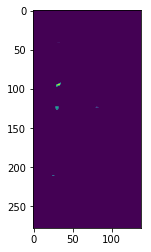

In [67]:
w1 = 1
w2 = 1
w3 = 1
w = np.ones((3,3,3))
b = -7200
a = 800
out = np.zeros((278,138))
for i in range(278) :
    for j in range(138) :
        temp = np.sum(img[i:i+3,j:j+3,:]*w) + b
#         print temp
        out[i,j] = np_channel(temp, a)
plt.imshow(out)

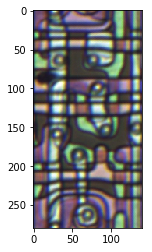

In [29]:
plt.imshow(img)

In [6]:
# Build 
x_resize = tools.resize(V, x)
x_std = tools.zero_channel(V, x_resize)
[loss, opt, corPred, acc, pred_test, loss_avg, acc_avg] = current_model(V, x_std, y_hot, cord_grid,
                                                                      phase, keep_prob, learning_rate)

Structure build Complete
